In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [11]:
df = pd.read_csv('../Dataset/dfPlayerFinal_2025.csv')
role_map = {
    "RW": "Attaccante", 
    "SS": "Attaccante", 
    "CF": "Attaccante", 
    "LW": "Attaccante",
    "CM": "Centrocampista", 
    "LM": "Centrocampista", 
    "AM": "Centrocampista",
    "DM": "Difensore", 
    "CB": "Difensore", 
    "RB": "Difensore",
    "LB": "Difensore", 
    "Defender": "Difensore", 
    "SW": "Difensore",
    "GK": "Portiere"
}
df_role = df
df_role['macro_role'] = df_role['role'].map(role_map)
df_role = (
    df.groupby(["role","macro_role", "nazionality", "rank"])
      .size()
      .reset_index(name="counter")
)
df_role.loc[df_role['role'].isin(['LB', 'RB']), 'macro_role'] = 'Difensore'
df_role.to_csv('../Dataset/df_role.csv', index=False)
display(df_role)
df["role"] = df["role"].map(role_map)

,role,macro_role,nazionality,rank,counter
0,AM,Centrocampista,Belgio,3rd,1
1,AM,Centrocampista,Brasile,1st,2
2,AM,Centrocampista,Finlandia,3rd,1
3,AM,Centrocampista,Francia,1st,4
4,AM,Centrocampista,Francia,2nd,2
...,...,...,...,...,...
117,SS,Attaccante,Ucraina,1st,1
118,SW,Difensore,Germania,1st,3
119,SW,Difensore,Germania,2nd,2
120,SW,Difensore,Germania,3rd,1


In [3]:
# Raggruppa i dati per 'role' e 'nazionality', conta i giocatori e calcola il rank
df_summary = (
    df.groupby(["role", "nazionality", "rank"])
      .size()
      .reset_index(name="counter")
)
# Visualizza il nuovo dataset
display(df_summary)

df_summary.to_csv('../Dataset/dfHeapmap.csv', index=False)

,role,nazionality,rank,counter
0,Attaccante,Argentina,1st,8
1,Attaccante,Argentina,2nd,5
2,Attaccante,Argentina,3rd,1
3,Attaccante,Austria,2nd,1
4,Attaccante,Brasile,1st,1
...,...,...,...,...
87,Difensore,Spagna,2nd,1
88,Portiere,Germania,3rd,3
89,Portiere,Italia,2nd,2
90,Portiere,Repubblica Ceca,3rd,1


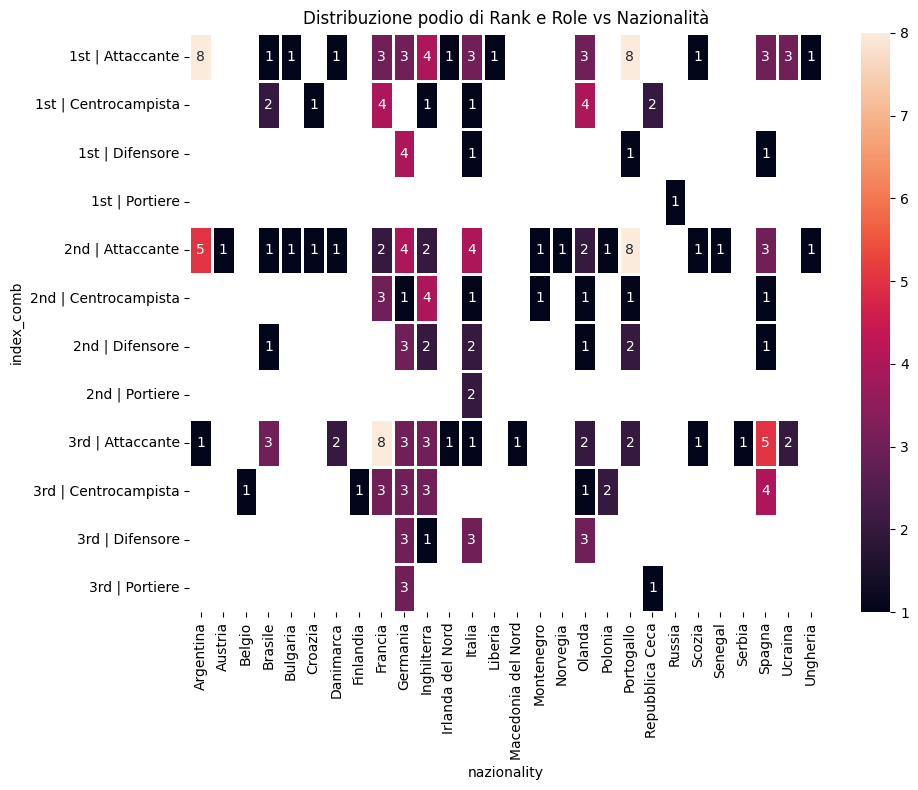

In [4]:
df_summary["index_comb"] = df_summary["rank"] + " | " + df_summary["role"]

summary = (
    df_summary
    .pivot(index="index_comb", columns="nazionality", values="counter")
)

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(summary, annot=True, fmt=".0f", linewidths=.9, ax=ax)
plt.title("Distribuzione podio di Rank e Role vs Nazionalità")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

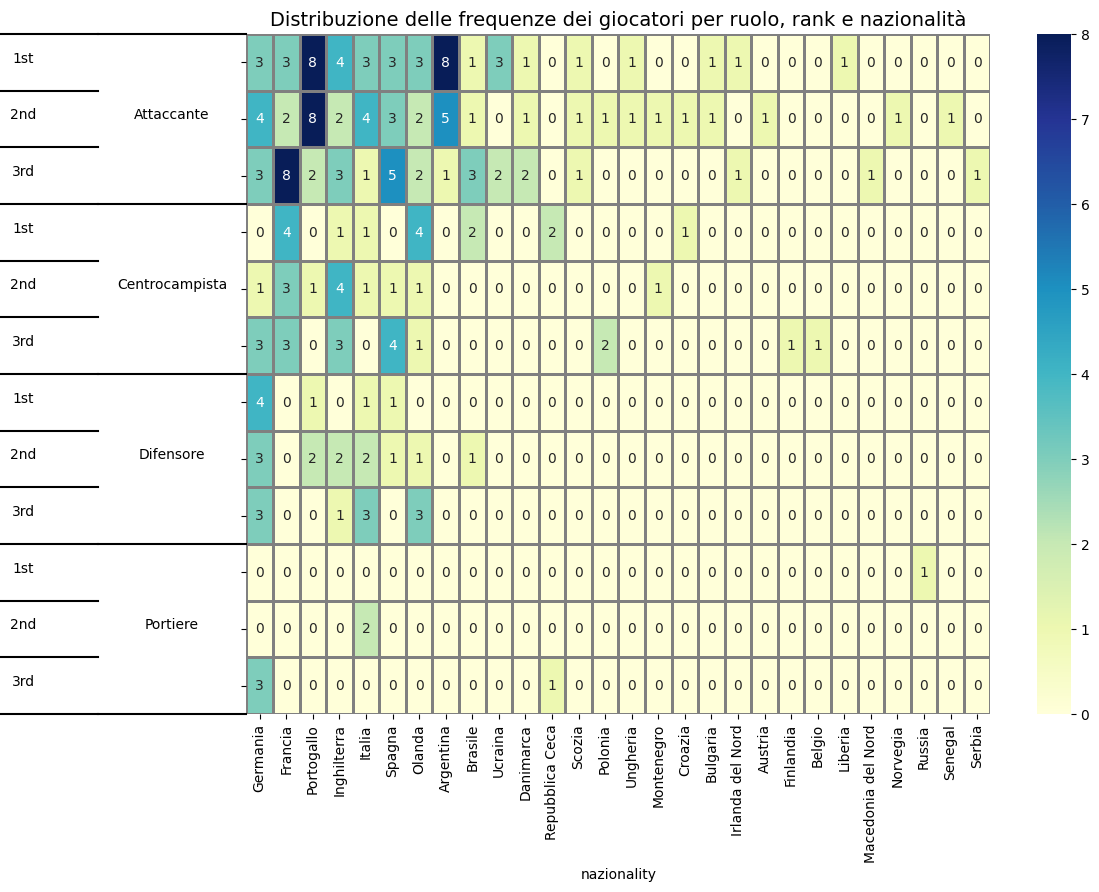

In [1]:
#HeapMap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby


df = pd.read_csv('../Dataset/dfHeapmap.csv')

# --- Funzioni per etichette raggruppate ---
def add_line(ax, xpos, ypos):
    line = plt.Line2D([ypos, ypos + 0.2], [xpos, xpos], color='black', transform=ax.transAxes)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index, level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for _ in g)) for k, g in groupby(labels)]

def label_group_bar_table(ax, df):
    xpos = -0.2
    scale = 1. / df.index.size
    for level in range(df.index.nlevels):
        pos = df.index.size
        for label, rpos in label_len(df.index, level):
            add_line(ax, pos * scale, xpos)
            pos -= rpos
            lypos = (pos + 0.5 * rpos) * scale
            ax.text(xpos + 0.1, lypos, label, ha='center', transform=ax.transAxes)
        add_line(ax, pos * scale, xpos)
        xpos -= 0.2

# --- Crea pivot table con MultiIndex per heatmap ---
df_pivot = df.pivot_table(index=['role', 'rank'], columns='nazionality', values='counter', aggfunc='sum').fillna(0)
df_pivot = df_pivot[df_pivot.sum(axis=0).sort_values(ascending=False).index]

# --- Visualizzazione con heatmap e raggruppamento etichette ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
sns.heatmap(df_pivot, ax=ax, annot=True, fmt=".0f", cmap='YlGnBu', linewidths=1, linecolor='gray')
# Rimuove le etichette automatiche sull'asse Y
ax.set_yticklabels(['' for _ in ax.get_yticklabels()])
ax.set_ylabel('')

# Aggiunge le etichette raggruppate
label_group_bar_table(ax, df_pivot)

fig.subplots_adjust(bottom=0.1 * df_pivot.index.nlevels)
plt.title('Distribuzione delle frequenze dei giocatori per ruolo, rank e nazionalità', fontsize=14)
plt.show()

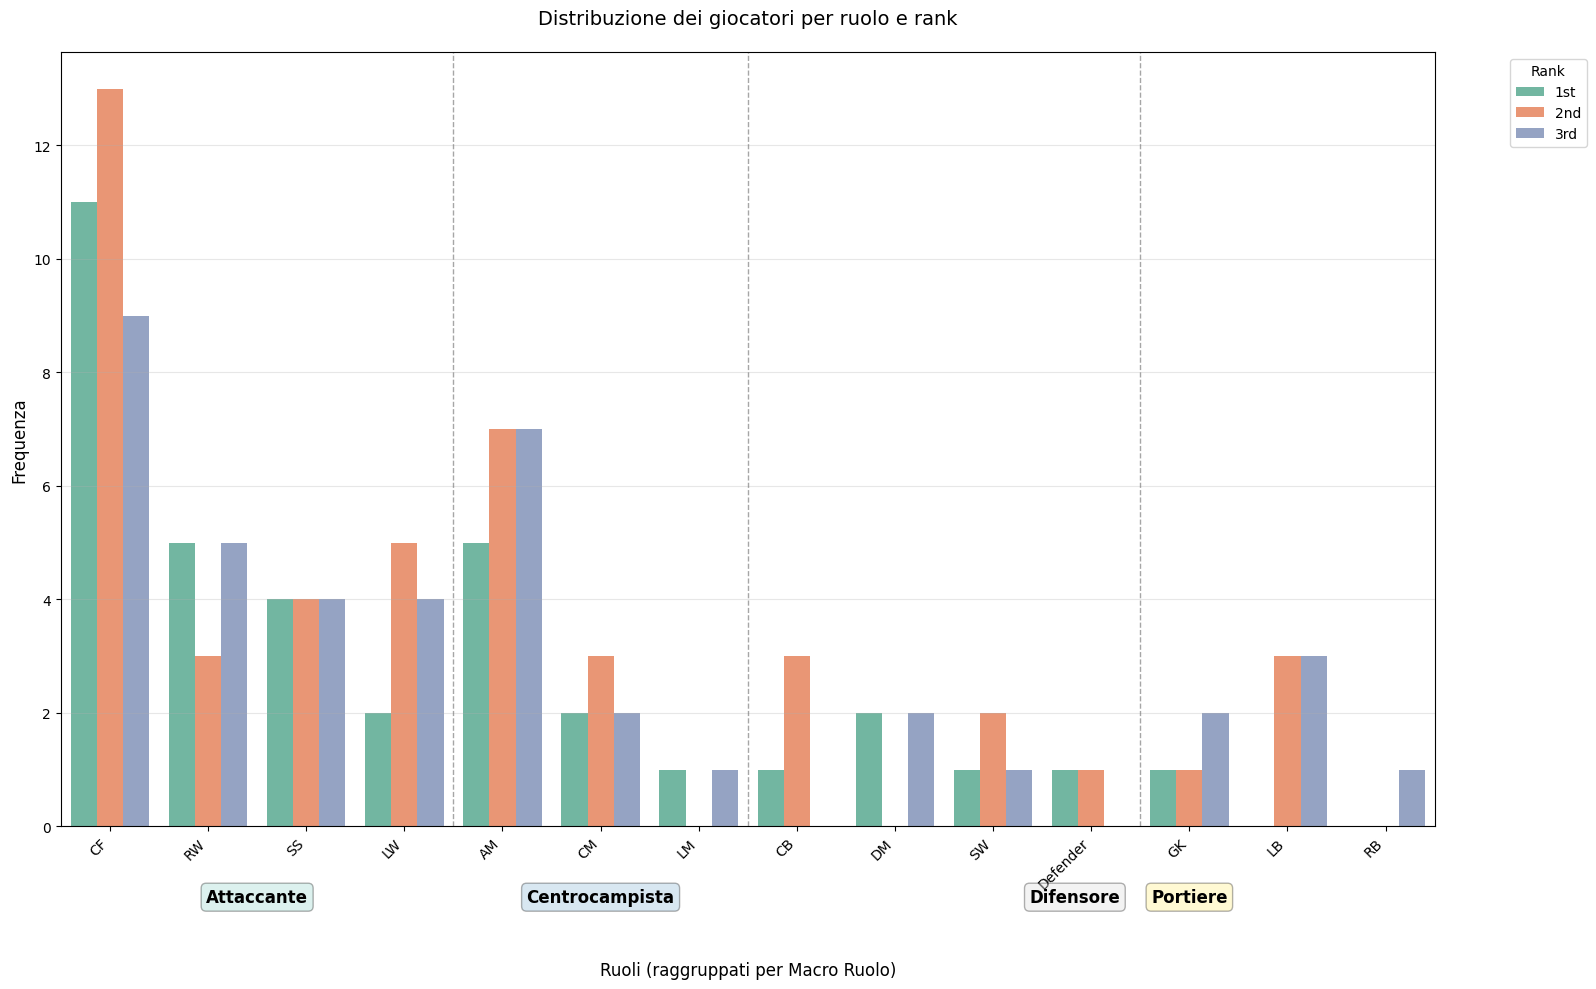

In [14]:
# Versione alternativa con multi-index più elegante
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Leggi i dati
df = pd.read_csv('../Dataset/df_role.csv')

# Raggruppa per macro_role, role, rank
df_grouped = df.groupby(['macro_role', 'role', 'rank']).size().reset_index(name='frequency')

# Crea una pivot table per una migliore gestione del multi-index
pivot_df = df_grouped.pivot_table(
    index=['macro_role', 'role'], 
    columns='rank', 
    values='frequency', 
    fill_value=0
).reset_index()

# Ordina per macro_role e frequenza totale (decrescente per i role)
pivot_df['total'] = pivot_df.iloc[:, 2:].sum(axis=1)
pivot_df = pivot_df.sort_values(['macro_role', 'total'], ascending=[True, False])

# Riconverti in formato long per seaborn
df_melted = pivot_df.drop('total', axis=1).melt(
    id_vars=['macro_role', 'role'], 
    var_name='rank', 
    value_name='frequency'
)
df_melted = df_melted[df_melted['frequency'] > 0]  # Rimuovi i valori zero

# Crea il plot
fig, ax = plt.subplots(figsize=(16, 10))

# Prepara le posizioni x
unique_roles = df_melted[['macro_role', 'role']].drop_duplicates()
x_positions = np.arange(len(unique_roles))

# Mapping per le posizioni
pos_mapping = {(row['macro_role'], row['role']): i 
               for i, (_, row) in enumerate(unique_roles.iterrows())}
df_melted['x_pos'] = df_melted.apply(
    lambda row: pos_mapping[(row['macro_role'], row['role'])], axis=1
)

# Crea il barplot
sns.barplot(
    data=df_melted,
    x='x_pos',
    y='frequency',
    hue='rank',
    palette='Set2',
    ax=ax
)

# Personalizza l'asse x con multi-index
ax.set_xticks(x_positions)

# Primo livello: role names
ax.set_xticklabels([row['role'] for _, row in unique_roles.iterrows()], 
                   rotation=45, ha='right', fontsize=10)

# Secondo livello: macro_role labels
macro_groups = {}
for i, (_, row) in enumerate(unique_roles.iterrows()):
    macro_role = row['macro_role']
    if macro_role not in macro_groups:
        macro_groups[macro_role] = []
    macro_groups[macro_role].append(i)

# Aggiungi etichette macro_role e separatori
y_offset = ax.get_ylim()[0] - 0.08 * (ax.get_ylim()[1] - ax.get_ylim()[0])
colors = plt.cm.Set3(np.linspace(0, 1, len(macro_groups)))

for idx, (macro_role, positions) in enumerate(macro_groups.items()):
    # Etichetta centrata
    center_pos = np.mean(positions)
    ax.text(center_pos, y_offset, macro_role, 
            ha='center', va='top', fontweight='bold', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[idx], alpha=0.3))
    
    # Linee di separazione
    if idx > 0:
        separator_pos = min(positions) - 0.5
        ax.axvline(x=separator_pos, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# Personalizza il grafico
ax.set_xlabel('Ruoli (raggruppati per Macro Ruolo)', fontsize=12, labelpad=50)
ax.set_ylabel('Frequenza', fontsize=12)
ax.set_title('Distribuzione dei giocatori per ruolo e rank', fontsize=14, pad=20)
ax.legend(title='Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

# Aggiungi spazio per le etichette
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

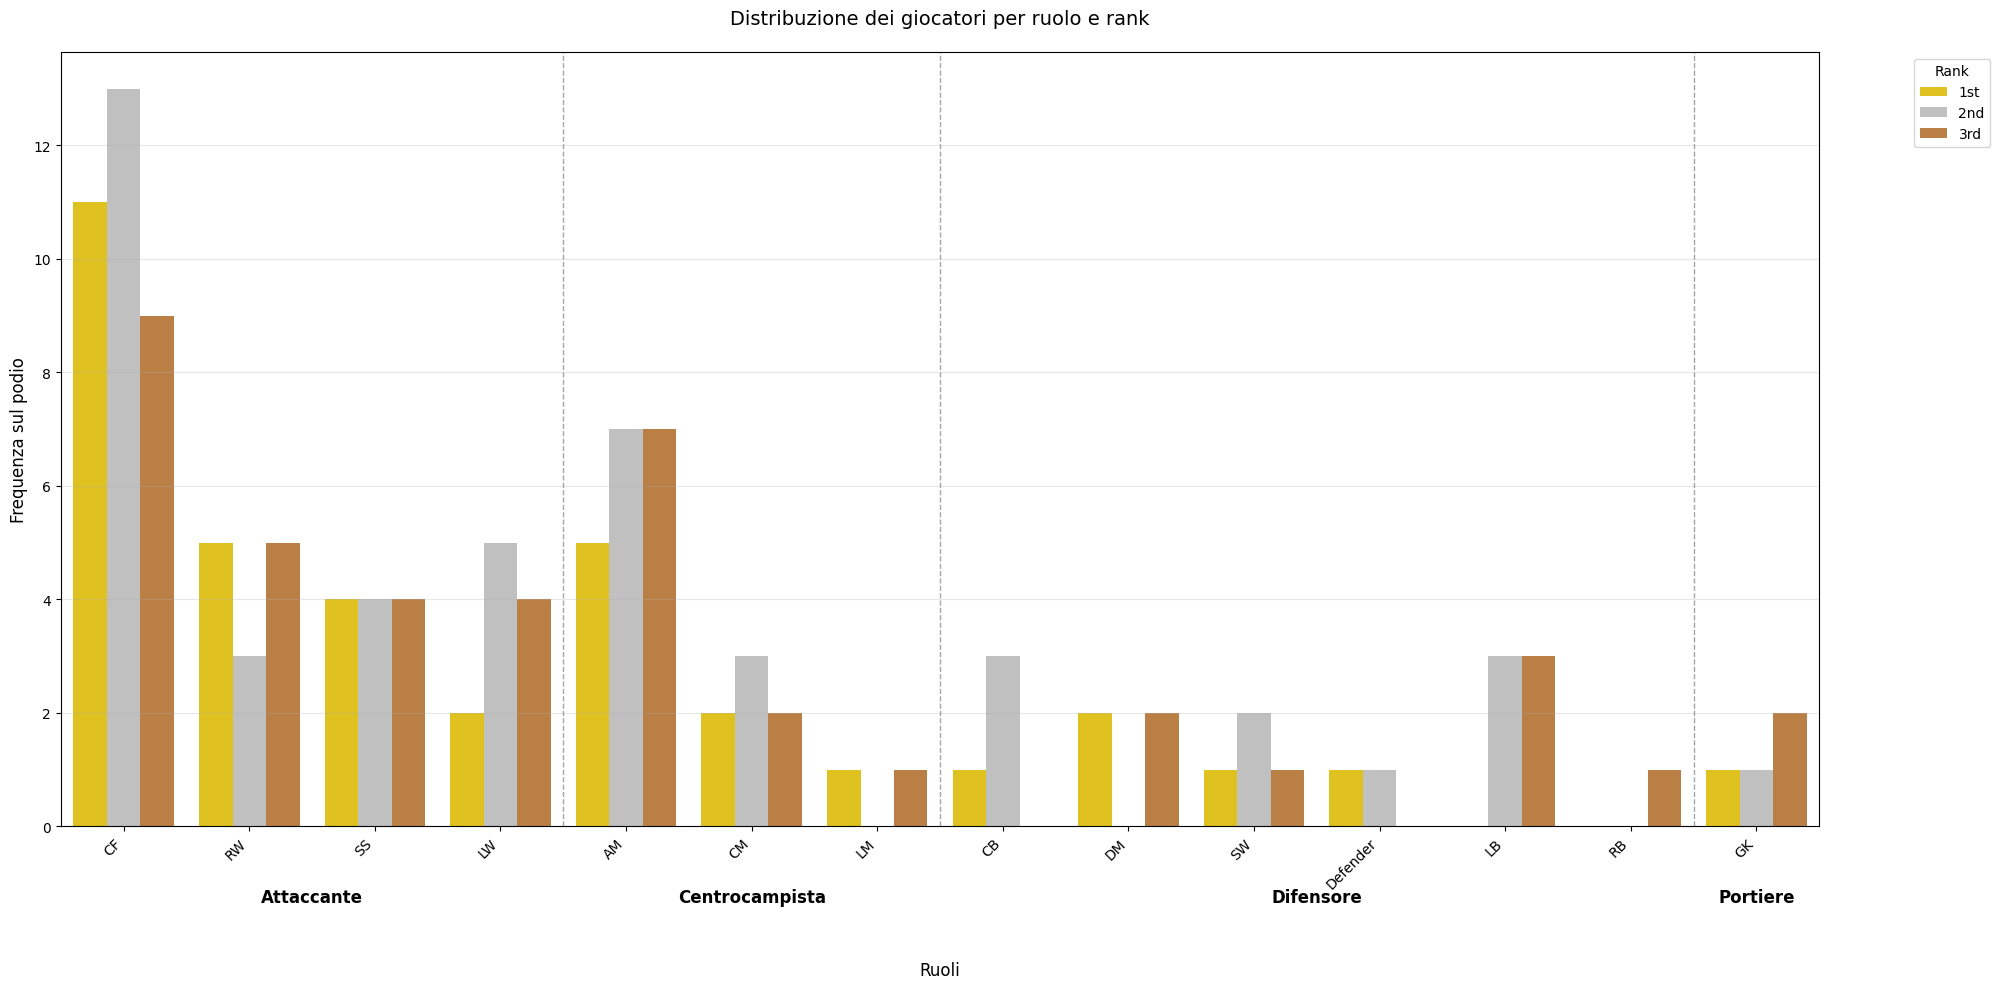

In [28]:
# Leggi e processa i dati
df = pd.read_csv('../Dataset/df_role.csv')
df_grouped = df.groupby(['macro_role', 'role', 'rank']).size().reset_index(name='frequency')

# Pivot e ordinamento (GK alla fine)
pivot_df = df_grouped.pivot_table(index=['macro_role', 'role'], columns='rank', values='frequency', fill_value=0).reset_index()
pivot_df['total'] = pivot_df.iloc[:, 2:].sum(axis=1)
pivot_df['is_gk'] = pivot_df['role'] == 'GK'
pivot_df = pivot_df.sort_values(['is_gk', 'macro_role', 'total'], ascending=[True, True, False])

# Melt per seaborn
df_melted = pivot_df.drop(['total', 'is_gk'], axis=1).melt(id_vars=['macro_role', 'role'], var_name='rank', value_name='frequency')
df_melted = df_melted[df_melted['frequency'] > 0]

# Setup plot
fig, ax = plt.subplots(figsize=(20, 10))
unique_roles = df_melted[['macro_role', 'role']].drop_duplicates()
unique_roles['is_gk'] = unique_roles['role'] == 'GK'
unique_roles = unique_roles.sort_values(by='is_gk').drop(columns='is_gk').reset_index(drop=True)

# Mapping posizioni x
pos_mapping = {(row['macro_role'], row['role']): i for i, (_, row) in enumerate(unique_roles.iterrows())}
df_melted['x_pos'] = df_melted.apply(lambda row: pos_mapping[(row['macro_role'], row['role'])], axis=1)

# Colori e plot
rank_colors = {'1st': '#FFD700', '2nd': '#C0C0C0', '3rd': '#CD7F32'}
sns.barplot(data=df_melted, x='x_pos', y='frequency', hue='rank', palette=rank_colors, ax=ax)

# Personalizzazione assi
ax.set_xticks(range(len(unique_roles)))
ax.set_xticklabels([row['role'] for _, row in unique_roles.iterrows()], rotation=45, ha='right', fontsize=10)

# Etichette macro_role e separatori
macro_groups = {}
for i, (_, row) in enumerate(unique_roles.iterrows()):
    macro_groups.setdefault(row['macro_role'], []).append(i)

y_offset = ax.get_ylim()[0] - 0.08 * (ax.get_ylim()[1] - ax.get_ylim()[0])
for idx, (macro_role, positions) in enumerate(macro_groups.items()):
    ax.text(np.mean(positions), y_offset, macro_role, ha='center', va='top', fontweight='bold', fontsize=12)
    if idx > 0:
        ax.axvline(x=min(positions) - 0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1)

# Finalizzazione
ax.set_xlabel('Ruoli', fontsize=12, labelpad=50)
ax.set_ylabel('Frequenza sul podio', fontsize=12)
ax.set_title('Distribuzione dei giocatori per ruolo e rank', fontsize=14, pad=20)
ax.legend(title='Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()